<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%2015/Anda_Figo_HaqClustering_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image clustering with CLIP

In this notebook, we explore how to use CLIP and FAISS to cluster images.
We will apply the following steps:
* Install required packages
* Load a dataset (CIFAR10 here)
* Make 10 clusters as there are 10 classes in the dataset
* Display distribution of the 10 classes in the clusters

## Install required packages

In [1]:
pip install transformers torch datasets matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Install FAISS with GPU or CPU support
For CPU only, install faiss-cpu.
For GPU, install faiss-gpu.
Uncomment the line below that fits your hardware and run.

In [2]:
#pip install faiss-gpu
#pip install faiss-cpu

## Load CLIP: model and processor using transformers
Firstly, import the required packages.
Then, define the device to use (i.e gpu or cpu).
Lastly, load CLIP model and processor using Transformers.

In [6]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 43.5 MB/s eta 0:00:00


In [7]:
#Import packages
import torch
from transformers import AutoProcessor, CLIPModel, AutoImageProcessor
from datasets import load_dataset
import faiss
import numpy as np
import time

#Define device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model and processor
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Load CIFAR 10 dataset
We use this dataset as it has 10 pre-defined classes.

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

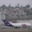

In [8]:
#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

## Extract the features of all images in the test set (10K images) and store them in a FAISS index
In order to create clusters, we need to extract the features of all the images of the dataset.
We will store the features in a FAISS index. The dimensionality of the features is 512 for the clip-vit-base-patch32 model. Therefore, we create an index with the parameter 512.
We define 2 functions for this purpose:
* extract_features_clip: takes an image as input and return its features.
* add_vector_to_index: add the image features to a FAISS index. Before, it preprocesses the vector to fit FAISS requirements (i.e. numpy float 32 vector) and normalizes the vector.

Lastly, we iterate over the dataset to extract and store the features.


In [13]:
print(type(dataset['test'][0]))
print(dataset['test'][0])


<class 'dict'>
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A30D9525F60>, 'label': 3}


In [22]:
print(clip_features.shape)


torch.Size([1, 512])


In [ ]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#Create FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in dataset['test']:
    clip_features = extract_features_clip(image['img'])
    add_vector_to_index(clip_features,index)

#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"clip.index")

## Create 10 clusters

Firstly, we need to retrieve all the vectors.
Then, we define the parameters we want to apply for the clustering:
* ncentroids: number of clusters to make.
* niter: number of iterations performed during the k-means clustering process.
* d: dimensionality of the vectors (512 here).

Lastly, we apply k-means clustering to the vectors.


## Create a matrix to store the distribution of vectors in the cluster and visualise it
Create an empty 10x10 matrix to store the distribution of the clusters.

In [ ]:
#Retrieve the vectors
vectors = index.reconstruct_n(0, 10000)

#Define clusters and parameters
x= vectors
ncentroids = 10
niter = 50
verbose = True
d = x.shape[1]

t0=time.time()
#Launch clustering
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)
print('Clustering done in ', time.time()-t0)

#cluster assignments: [array of vectors, array of indices (cluster assigned to a given vector)]
cluster_assignments = kmeans.assign(vectors)
print(cluster_assignments)
#Print indices only
clusters_ind = cluster_assignments[1]
print(clusters_ind)

In [ ]:
distribution = np.zeros((10, 10), dtype=int)
print(distribution)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


Iterate over the the array of cluster assignement to populate the matrix. x-axis is the cluster ID, while y-axis is the label of the image (value between 0 and 9).
The matrix can be read as follows:
* distribution[0][0]: for cluster 1, number of images labelled 0.
* distribution[0][1]: for cluster 1, number of images labelled 1.
...


In [ ]:
for vector_index,cluster_nb in enumerate(clusters_ind):
    label = dataset['test'][vector_index]['label']
    distribution[cluster_nb][label]+=1

print(distribution)


[[821   3   9   1   1   0   0   1  26   0]
 [  0   0  61  12 764  14   6  26   0   0]
 [  0   0   1   0   9   3   0 861   0   0]
 [ 15   0   2   0   0   0   0   0 912   6]
 [132  20 148 179 155 131 244  99  45  37]
 [ 13   0 102  41  59   6 736   1   2   1]
 [  0   0   3  19   2 780   2   8   0   0]
 [ 12 976   0   2   1   2   0   0  15 956]
 [  0   1   9 743   7  62   8   3   0   0]
 [  7   0 665   3   2   2   4   1   0   0]]


Sum up number of images per cluster to understand how many images were assigned for each cluster.

In [ ]:
row_sums = np.sum(distribution, axis=1)
print("Number of images per cluster:")
print(row_sums)

Number of images per cluster:
[ 862  883  874  935 1190  961  814 1964  833  684]


Plot distribution of labels per cluster.

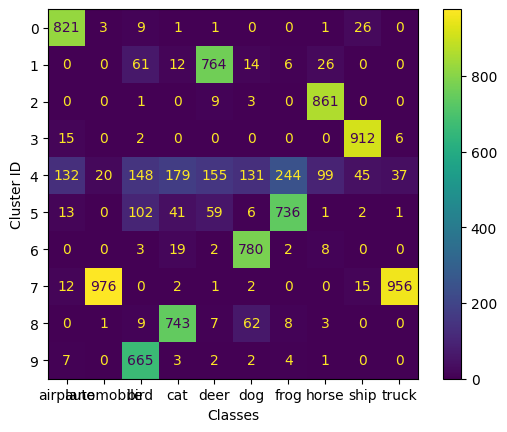

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=distribution)
disp.plot()
plt.ylabel('Cluster ID')
plt.xlabel('Classes')
labels = dataset["train"].features["label"].names
x = range(len(labels))
ticks = labels
plt.xticks(x, ticks)
plt.show()